<a href="https://colab.research.google.com/github/RebatiGaire/TensorflowInPractice/blob/master/horses_vs_humans_using_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-04-08 10:54:34--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   105MB/s    in 0.8s    

2020-04-08 10:54:35 (105 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(include_top=False, weights= None,input_shape= (150, 150, 3))
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [7]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape : ', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape :  (None, 7, 7, 768)


In [15]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [19]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 


local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()



--2020-04-08 11:26:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   108MB/s    in 1.3s    

2020-04-08 11:26:50 (108 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-04-08 11:26:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/z

In [20]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')


train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [21]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True

)

test_datagen = ImageDataGenerator(rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 8,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))  

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                    batch_size = 8,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [22]:
history = model.fit_generator(train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 128,
            epochs = 20,
            validation_steps = 32,
            verbose = 1,
            callable = [callbacks])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
128/128 [==============================] - 96s 752ms/step - loss: 0.0870 - accuracy: 0.9727 - val_loss: 0.0446 - val_accuracy: 0.9883
Epoch 2/20
128/128 [==============================] - 93s 726ms/step - loss: 0.0248 - accuracy: 0.9872 - val_loss: 0.2563 - val_accuracy: 0.9570
Epoch 3/20
128/128 [==============================] - 95s 739ms/step - loss: 0.0464 - accuracy: 0.9843 - val_loss: 9.0596e-05 - val_accuracy: 1.0000
Epoch 4/20
128/128 [==============================] - 93s 726ms/step - loss: 0.0229 - accuracy: 0.9912 - val_loss: 0.0191 - val_accuracy: 0.9961
Epoch 5/20
128/128 [==============================] - 93s 726ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 3.1175e-05 - val_accuracy: 1.0000
Epoch 6/20
128/128 [==============================] - 93s 724ms/step - loss: 0.0254 - accuracy: 0.9951 - val_loss: 0.0101 - val_accuracy: 0.9961
Epoch 7/20
128/128 [==========================

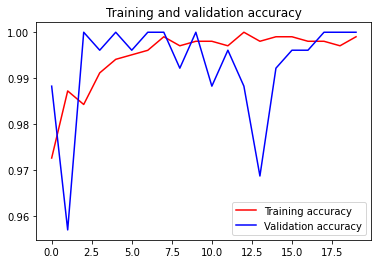

<Figure size 432x288 with 0 Axes>

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()